In [199]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data import sampler, Subset

import torchvision.datasets as dset
import torchvision.transforms as T

from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import LinearSVC
# from sklearn.linear_model import LogisticRegression

from PIL import Image

# constants
repo_path = Path('/Users/etriesch/dev/tree-finder/')
model_path = repo_path / 'models'

In [183]:
# setup cell
USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 200
print('using device:', device)

using device: cpu


In [184]:
# setup cell
from plot_fns import show_image_batch, set_plt_settings
from train_fns import flatten, Flatten, check_accuracy, train_model

# And change jupyter settings to auto-reload these functions before each instance running them
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
set_plt_settings()

# Make dataset and loaders
This includes augmenting my dataset

In [193]:
# make dataset
SCALE = 1024
CROP = SCALE
SCALE_TEMP = 64 # for training

# define transformations
transforms = {}
transforms['orig'] = T.Compose([T.Resize(SCALE), T.CenterCrop(CROP), 
                       T.Resize(SCALE_TEMP),
                       T.ToTensor()])
transforms['mirr'] = T.Compose([T.Resize(SCALE), T.CenterCrop(CROP), T.RandomHorizontalFlip(1), 
                       T.Resize(SCALE_TEMP),
                       T.ToTensor()])

# include a random cropping (flipped and unflipped) at three crop sizes
for pct in [10, 25, 50]:
    scale_param = int(1 / (pct*0.01))
    transforms[f'crop{pct}'] = T.Compose([T.Resize(scale_param*SCALE), T.RandomResizedCrop(CROP),
                                          T.Resize(SCALE_TEMP),
                                          T.ToTensor()])
    transforms[f'crop{pct}_mirr'] = T.Compose([T.Resize(scale_param*SCALE), T.RandomResizedCrop(CROP),
                                               T.RandomHorizontalFlip(1),
                                               T.Resize(SCALE_TEMP),
                                               T.ToTensor()])

In [194]:
# create dataset by concatenating all transformations
treeds = []
for t in transforms:
    df = dset.ImageFolder(root=repo_path / 'data/images_spec', transform=transforms[t])
    treeds.append(df)

treeds = ConcatDataset(treeds)
classes = treeds.datasets[0].classes

In [195]:
# make dataloaders
N = len(treeds)

# make whole-dataset loader and subset loader
loader_all = DataLoader(dataset=treeds, batch_size=N, shuffle=False)
loader_samp = DataLoader(dataset=treeds, batch_size=4, shuffle=True)

(train, val, test): 24624 4924 3284


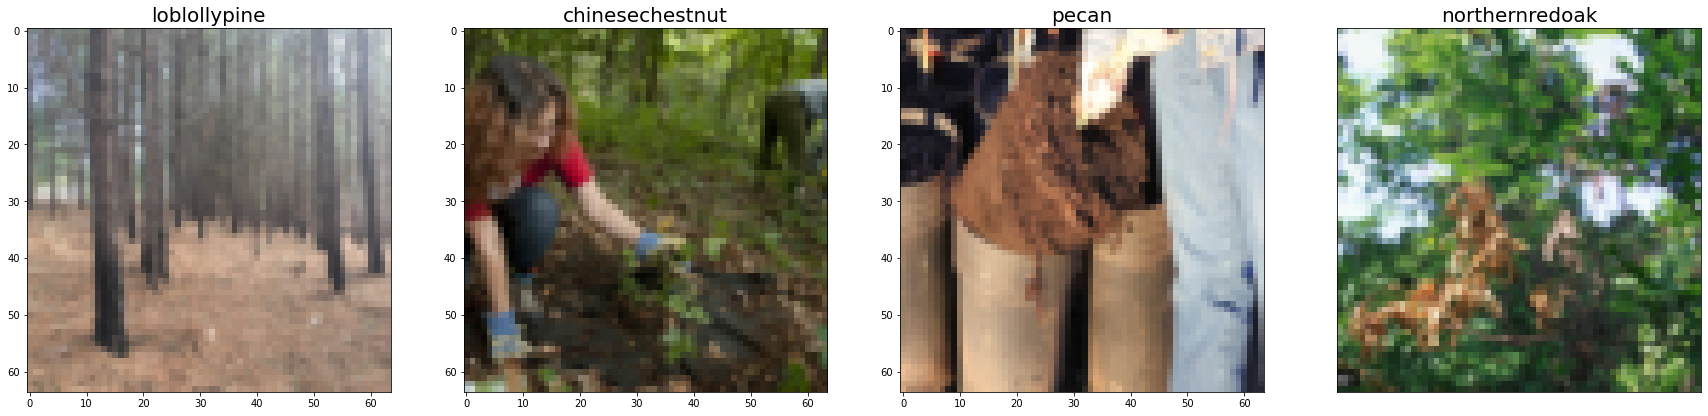

In [196]:
# visualize images
trainiter = iter(loader_samp)
imgs, labels = trainiter.next()

# print(type(imgs), type(labels))
show_image_batch(imgs, title=[classes[x] for x in labels])

# Run through trained tree-classification model

In [203]:
# load training weights into model
num_classes = 2
pt_net = models.resnet18(pretrained=True)
pt_net.fc = nn.Linear(pt_net.fc.in_features, num_classes)
pt_net = pt_net.to(device)
pt_net.load_state_dict(torch.load(model_path / 'resnet.pt', map_location=device))
pt_net.eval() # put model in eval mode

FileNotFoundError: [Errno 2] No such file or directory: '/Users/etriesch/dev/tree-finder/models/resnet.pt'

In [40]:
# tranform images to be compatible with imagenet
SCALE_IMGNET = 256 
resnet_transform = T.Compose([T.Resize(SCALE), T.CenterCrop(CROP), 
                               T.Resize(SCALE_IMGNET), 
                               # T.ToTensor(),
                               T.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])])
# load all images
filter_iter = iter(loader_samp)
X_in, __ = filter_iter.next()
# transform
X_in = resnet_transform(X_in)
# mount to right processor
X_in = X_in.to(device=device, dtype=dtype)  # move to device, e.g. GPU

In [217]:
# get scores for all images
scores = pt_net(X_in)
percentage = torch.nn.functional.softmax(scores, dim=1) * 100

In [218]:
# subset to images that pass tree threshold
tree_likelihood = percentage[1]
tree_class_threshold = 0.9
tree_idxs = np.arange(0, len(treeds))[tree_likelihood >= tree_class_threshold].tolist()

# subset the dataset
treeds_sub = torch.utils.data.Subset(treeds, tree_idxs)



IndexError: boolean index did not match indexed array along dimension 0; dimension is 32832 but corresponding boolean dimension is 2

# Make train/test dataloaders 

In [195]:
# make dataloaders
PCT_TRAIN, PCT_VAL = 0.75, 0.15
N = len(treeds)
num_train = int(N * PCT_TRAIN)
num_val = int(N * PCT_VAL)
num_test = N - num_train - num_val
print('(train, val, test):', num_train, num_val, num_test)


# make whole-dataset loader and subset loader
loader_train = DataLoader(treeds, batch_size=64,
                           sampler=sampler.SubsetRandomSampler(range(num_train)))
loader_val = DataLoader(treeds, batch_size=64,
                           sampler=sampler.SubsetRandomSampler(range(num_train, num_train+num_val)))
loader_test = DataLoader(treeds, batch_size=64,
                           sampler=sampler.SubsetRandomSampler(range(num_train+num_val, N)))

(train, val, test): 24624 4924 3284


## Baseline models

In [67]:
NUM_CLASSES = 7

### Random guessing

In [68]:
mr_random = 1 / NUM_CLASSES
print(mr_random)

0.14285714285714285


### KNN

In [69]:
# helper functions
top_k_accuracy_set = metrics.make_scorer(metrics.top_k_accuracy_score, k=1)
precision_set = metrics.make_scorer(metrics.precision_score, average=None)
scoring = {'accuracy': 'accuracy',
#            'top_5_accuracy':top_k_accuracy_set,
#            'precision': precision_set,
#            'recall': 'recall'
          }

def run_cv(X, y, estimator, params, scoring):
    # run grid search for hyperparameters
    grid_search = GridSearchCV(
                estimator=estimator, 
                param_grid=params,
                scoring=scoring,
                cv=2,
                refit=False)

    cv = grid_search.fit(X, y)

    return cv.cv_results_

In [70]:
# get data
loader_all = DataLoader(treeds, batch_size=num_train+num_val, 
                        sampler=sampler.SubsetRandomSampler(range(0, num_train+num_val)))
X  = flatten(next(iter(loader_all))[0]).numpy()
y = next(iter(loader_all))[1].numpy()

UnidentifiedImageError: cannot identify image file <_io.BufferedReader name='/Users/etriesch/dev/tree-finder/data/images/loblollypine/bing-loblolly-pine-bark-576x1024.jpg'>

In [354]:
k_range = range(5, 200, 5)
params={'n_neighbors': k_range}
cv_mean = run_cv(X, y, KNeighborsClassifier(), params, scoring)

In [355]:
mr_knn = cv_mean['mean_test_accuracy'].min()
print(mr_knn)

0.15487950430432462


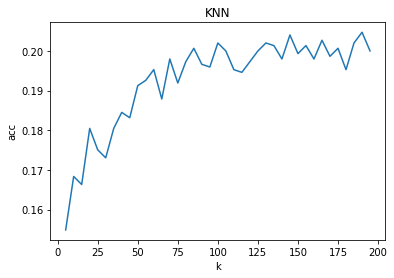

In [356]:
# plot results
plt.plot(k_range, cv_mean['mean_test_accuracy'])

xlab, ylab, title = 'k', 'acc', 'KNN'
plt.xlabel(xlab), plt.ylabel(ylab), plt.title(title)
plt.show()

#### Logistic

In [366]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
params={'penalty': ['l2'], #'l1', 'elasticnet', 'none'
        'C': [1, 10]}

cv_mean = run_cv(X_scaled, y, LogisticRegression(random_state=1, solver='sag'), params, scoring)

/Users/etriesch/dev/tree-finder/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/etriesch/dev/tree-finder/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


KeyboardInterrupt: 

In [358]:
mr_log = cv_mean['mean_test_accuracy'].min()
print(mr_log)

0.16699437336071077


### Logistic regression

In [385]:
hidden_layer_size = 128
learning_rate = 5e-3

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * SCALE_TEMP * SCALE_TEMP, NUM_CLASSES)
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train_model(model, optimizer, nn.CrossEntropyLoss(), epochs=10)
# FOR SVM: MultiLabelMarginLoss

Iteration 0, loss = 1.942
Got 0 / 247 correct (0.00)



/Users/etriesch/dev/tree-finder/lib/python3.9/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Iteration 0, loss = 2.26
Got 0 / 247 correct (0.00)

Iteration 0, loss = 1.351
Got 25 / 247 correct (10.12)

Iteration 0, loss = 1.883
Got 27 / 247 correct (10.93)

Iteration 0, loss = 1.359
Got 48 / 247 correct (19.43)

Iteration 0, loss = 2.822
Got 24 / 247 correct (9.72)

Iteration 0, loss = 1.926
Got 44 / 247 correct (17.81)

Iteration 0, loss = 1.507
Got 51 / 247 correct (20.65)

Iteration 0, loss = 1.508
Got 63 / 247 correct (25.51)

Iteration 0, loss = 1.264
Got 40 / 247 correct (16.19)



0.16194331983805668

### Fully connected single layer

In [ ]:
hidden_layer_size = 128
learning_rate = 1e-2

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * SCALE_TEMP * SCALE_TEMP, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, NUM_CLASSES),
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train_model(model, optimizer, F.cross_entropy, epochs=10)

Iteration 0, loss = 1.94
Got 0 / 247 correct (0.00)

Iteration 0, loss = 1.761
Got 0 / 247 correct (0.00)

Iteration 0, loss = 1.566
Got 0 / 247 correct (0.00)

Iteration 0, loss = 1.7
Got 0 / 247 correct (0.00)

Iteration 0, loss = 1.828
Got 0 / 247 correct (0.00)

Iteration 0, loss = 1.424
Got 32 / 247 correct (12.96)

